In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from pathlib import Path


In [9]:
# Load the uploaded CSV file
file_path = "concrete_training_data.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.head()

,Mix,Cement type,Cement [%],Crushed gravel [%],Sharp sand [%],Water [%],Estimated mass [kg/m3],Pre-conditioning time [days],Carbonation coefficient K4% [mm/day^1/2],Environmental impact [kgCO2e/kg],Compressive strength fcube [MPa],Water sat. density [kg/m3],Cost [£/kg]
0,C25 I,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,141.0,1.742,0.095,27.46,2337,0.025
1,C25 II,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,138.0,2.301,0.095,21.30,2317,0.025
2,C25 III,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,16.0,1.648,0.095,28.35,2300,0.025
3,C25 IV,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,16.0,2.081,0.095,29.87,2297,0.025
4,C20 I,IIA 32.5 R,10.0,56.0,27.4,6.5,2448,141.0,3.493,0.087,22.49,2263,0.024


In [13]:
name_map = {
    "Mix": "mix",
    "Cement type": "cement_type",
    "Cement [%]": "cement_per",
    "Crushed gravel [%]": "crushed_gravel_per",
    "Sharp sand [%]": "sharp_sand_per",
    "Water [%]": "water_per",
    "Estimated mass [kg/m3]": "estimated_mass",
    "Pre-conditioning time [days]": "preconditioning_time",
    "Carbonation coefficient K4% [mm/day^1/2]": "carbonation_coefficient",
    "Environmental impact [kgCO2e/kg]": "environmental_impact",
    "Compressive strength fcube [MPa]": "compressive_strength",
    "Water sat. density [kg/m3]": "water_sat_density",
    "Cost [£/kg]": "cost_per_kg"
}
# Rename columns for easier access
df.rename(columns=name_map, inplace=True)
df.head()

,mix,cement_type,cement_per,crushed_gravel_per,sharp_sand_per,water_per,estimated_mass,preconditioning_time,carbonation_coefficient,environmental_impact,compressive_strength,water_sat_density,cost_per_kg
0,C25 I,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,141.0,1.742,0.095,27.46,2337,0.025
1,C25 II,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,138.0,2.301,0.095,21.30,2317,0.025
2,C25 III,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,16.0,1.648,0.095,28.35,2300,0.025
3,C25 IV,IIA 32.5 R,11.1,52.8,28.1,7.8,2414,16.0,2.081,0.095,29.87,2297,0.025
4,C20 I,IIA 32.5 R,10.0,56.0,27.4,6.5,2448,141.0,3.493,0.087,22.49,2263,0.024


In [21]:
# input data
X = df.drop(columns=["mix","cement_type","carbonation_coefficient", "environmental_impact", "compressive_strength", "water_sat_density", "cost_per_kg"])
# outpu data
y = df[["carbonation_coefficient", "environmental_impact", "compressive_strength", "water_sat_density", "cost_per_kg"]]


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
# df1: shape (n_samples, n_features_1)
# df2: shape (n_samples, n_features_2)

# Ensure df1 and df2 have the same index or row count
assert X.shape[0] == y.shape[0], "DataFrames must have the same number of rows"

# Create an empty correlation matrix
correlations = pd.DataFrame(index=X.columns, columns=y.columns)

# Compute correlations
for col1 in X.columns:
    for col2 in y.columns:
        correlations.loc[col1, col2] = X[col1].corr(y[col2])

# Convert to float (corr returns float, but DataFrame init creates object dtype)
correlations = correlations.astype(float)

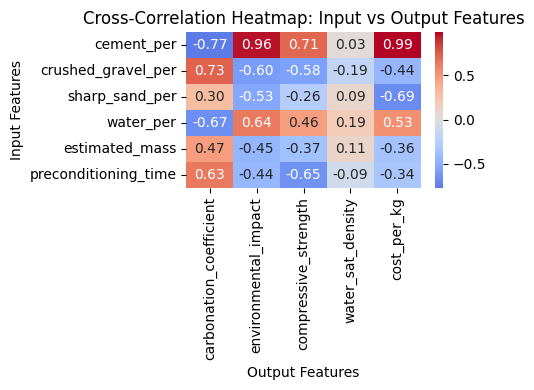

In [25]:
plt.figure(figsize=(5, 4))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Cross-Correlation Heatmap: Input vs Output Features")
plt.xlabel("Output Features")
plt.ylabel("Input Features")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# --- Split into inputs and outputs ---
X = df.drop(columns=["mix", "cement_type", "carbonation_coefficient", 
                     "environmental_impact", "compressive_strength", 
                     "water_sat_density", "cost_per_kg"])

y = df[["carbonation_coefficient", "compressive_strength"]]
y_carbonation = y["carbonation_coefficient"]
y_strength = y["compressive_strength"]

# --- Filter out missing carbonation values for Layer 1 training ---
mask_carbon = ~y_carbonation.isna()
X_carbon_train_full = X[mask_carbon]
y_carbon_train_full = y_carbonation[mask_carbon]

# --- Full dataset for Layer 2 (some carbonation values might be missing, but that's OK) ---
X_train_full, X_test_full, y_strength_train, y_strength_test = train_test_split(
    X, y_strength, test_size=0.2, random_state=42
)

# --- Train Layer 1 only on non-missing carbonation rows ---
rf_carbon = RandomForestRegressor(n_estimators=512, min_samples_split=2, max_features=6, random_state=0)
rf_carbon.fit(X_carbon_train_full, y_carbon_train_full)

def predict_with_uncertainty(rf_model, X_input):
    X_array = X_input.to_numpy() if hasattr(X_input, "to_numpy") else X_input
    all_preds = np.stack([tree.predict(X_array) for tree in rf_model.estimators_], axis=1)
    mean_pred = np.mean(all_preds, axis=1)
    std_pred = np.std(all_preds, axis=1)
    return mean_pred, std_pred


# --- Use the trained Layer 1 model to predict carbonation for full datasets ---
carbon_pred_train, carbon_std_train = predict_with_uncertainty(rf_carbon, X_train_full)
carbon_pred_test, carbon_std_test = predict_with_uncertainty(rf_carbon, X_test_full)

# --- Augment features for Layer 2 ---
X_train_aug = np.hstack([X_train_full, carbon_pred_train[:, None], carbon_std_train[:, None]])
X_test_aug = np.hstack([X_test_full, carbon_pred_test[:, None], carbon_std_test[:, None]])

# --- Train Layer 2 ---
rf_strength = RandomForestRegressor(n_estimators=512, min_samples_split=2, max_features=6, random_state=1)
rf_strength.fit(X_train_aug, y_strength_train)

# --- Predict and evaluate ---
y_strength_pred = rf_strength.predict(X_test_aug)

print("Compressive Strength Prediction Performance:")
print("R²:", r2_score(y_strength_test, y_strength_pred))
print("RMSE:", mean_squared_error(y_strength_test, y_strength_pred))


Compressive Strength Prediction Performance:
R²: 0.8917700468387476
RMSE: 9.827119566711037
